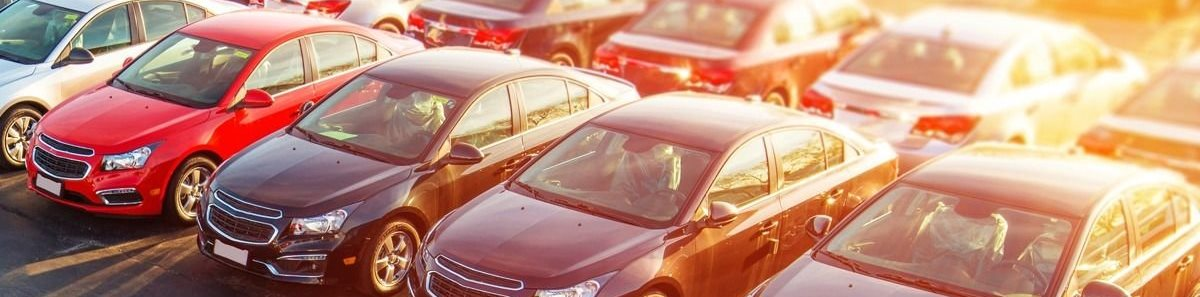

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

План работы:

1. Загрузить данные.
2. Изучите данные. Заполнить пропущенные значения и обработать аномалии в столбцах. 
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

## Подготовка данных

In [1]:
#pip install --upgrade category_encoders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import category_encoders

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import make_scorer


from catboost import CatBoostRegressor, Pool, cv

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from category_encoders import MEstimateEncoder


import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Удаление "лишних" столбцов

Удалим столбцы, которые не влияют на стоимость автомобиля
- LastSeen 
- NumberOfPictures
- PostalCode
- DateCreated
- RegistrationMonth
- DateCrawled 

In [6]:
remove_columns = ['LastSeen',
                  'NumberOfPictures',
                  'PostalCode',
                  'DateCreated',
                  'RegistrationMonth',
                   'DateCrawled']

df = data.drop(remove_columns,axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Удаление дубликатов

In [7]:
# проверим пропуски

df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Приведем все значения в столбцах типа object к нижнему регистру.

In [8]:
object_columns = ['VehicleType',
                  'Gearbox',
                  'Model',
                  'FuelType',
                  'Brand',
                  'Repaired']

for i in object_columns:
    df[i] = df[i].str.lower()
        

In [9]:
# Проверим на дубликаты

df.duplicated().sum()

45040

In [10]:
# удалим дубликаты

df = df.drop_duplicates()

df.duplicated().sum()

0

In [11]:
# снова проверим пропуски

df.isna().sum()

Price                   0
VehicleType         34559
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
Repaired            64558
dtype: int64

### Заполнение пропусков и удаление выбросов

In [12]:
# проверим пропуски по каждому из столбцов и за одно на неявные дубликаты и выбросы

df['VehicleType'].value_counts(dropna=False)

sedan          78206
small          67548
wagon          56367
NaN            34559
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: VehicleType, dtype: int64

Мы видим, что у нас есть по типу кузова тип other. Отнесем пропуски по типу кузова к этой категории.

In [13]:
df['VehicleType'] = df['VehicleType'].fillna('other')

df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
Repaired            64558
dtype: int64

In [14]:
# проверим столбец с годами регистрации

df['RegistrationYear'].value_counts(dropna=False)

2000    20840
2005    19350
1999    18876
2001    17234
2006    17201
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [15]:
df['RegistrationYear'].describe()

count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

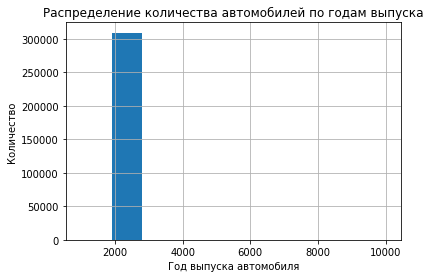

In [16]:
df['RegistrationYear'].hist(bins=10)

plt.xlabel("Год выпуска автомобиля")
plt.ylabel("Количество")
plt.title('Распределение количества автомобилей по годам выпуска')
plt.show()

Мы видим, что есть года, заполненные нелепыми данными. Нужно убрать выбросы.

Проверим максимальное значение столбца данных 'DateCrawled' и оставим этот года как лимит сверху.

In [17]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

Оставим года выпуска автомобилей с 1950 до 2016 года.

In [18]:
df = df.query('1950 <= RegistrationYear <= 2016')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295516 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295516 non-null  int64 
 1   VehicleType       295516 non-null  object
 2   RegistrationYear  295516 non-null  int64 
 3   Gearbox           280202 non-null  object
 4   Power             295516 non-null  int64 
 5   Model             279207 non-null  object
 6   Kilometer         295516 non-null  int64 
 7   FuelType          270167 non-null  object
 8   Brand             295516 non-null  object
 9   Repaired          236981 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


In [20]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             15314
Power                   0
Model               16309
Kilometer               0
FuelType            25349
Brand                   0
Repaired            58535
dtype: int64

In [21]:
# Рассмотрим столбец с данными по коробке передач

df['Gearbox'].value_counts(dropna=False)

manual    222741
auto       57461
NaN        15314
Name: Gearbox, dtype: int64

Чтобы не терять данные, заполним пропуски значением manual

In [22]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model               16309
Kilometer               0
FuelType            25349
Brand                   0
Repaired            58535
dtype: int64

In [23]:
# рассмотрим столбец со значениями мощности двигателя

df['Power'].describe()

count    295516.000000
mean        112.014896
std         198.037628
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

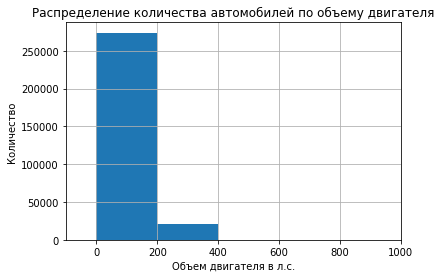

In [24]:
# видим выбросы, построим графики для наглядности

df['Power'].hist(bins=100)
plt.xlim([-100,1000])

plt.xlabel("Объем двигателя в л.с.")
plt.ylabel("Количество")
plt.title('Распределение количества автомобилей по объему двигателя')
plt.show()

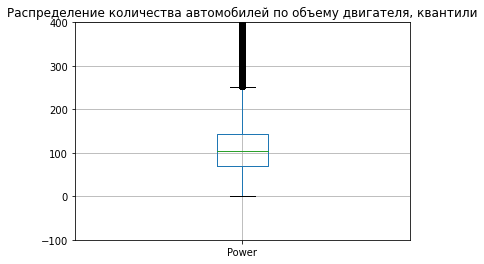

In [25]:

df.boxplot(column=['Power'])
plt.ylim([-100,400])

plt.title('Распределение количества автомобилей по объему двигателя, квантили')
plt.show()


Уберем данные с объемом двигателя менее 20 и более 250 л.с.

In [26]:
df = df.query('20 <= Power <= 250')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256255 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256255 non-null  int64 
 1   VehicleType       256255 non-null  object
 2   RegistrationYear  256255 non-null  int64 
 3   Gearbox           256255 non-null  object
 4   Power             256255 non-null  int64 
 5   Model             245428 non-null  object
 6   Kilometer         256255 non-null  int64 
 7   FuelType          240414 non-null  object
 8   Brand             256255 non-null  object
 9   Repaired          215358 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.5+ MB


In [28]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model               10827
Kilometer               0
FuelType            15841
Brand                   0
Repaired            40897
dtype: int64

In [29]:
df['Model'].value_counts()

golf          20191
other         18385
3er           14660
polo           8685
astra          7966
              ...  
samara            5
i3                5
kalina            4
serie_3           3
rangerover        2
Name: Model, Length: 248, dtype: int64

Видим, что есть много автомобилей other. Заполним пропуски этим значением.

In [30]:
df['Model'] = df['Model'].fillna('other')

df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType            15841
Brand                   0
Repaired            40897
dtype: int64

In [31]:
df['Kilometer'].value_counts(dropna=False)

150000    166537
125000     28275
100000     11497
90000       9228
80000       8130
70000       7133
60000       6050
50000       5117
40000       4030
30000       3504
20000       2981
5000        2925
10000        848
Name: Kilometer, dtype: int64

С данными по пробегу все хорошо. Переходим к следующему столбцу.

In [32]:
df['FuelType'].value_counts(dropna=False)

petrol      159938
gasoline     75777
NaN          15841
lpg           3938
cng            448
hybrid         189
other           82
electric        42
Name: FuelType, dtype: int64

Заполняем пропуски значением other.

In [33]:
df['FuelType'] = df['FuelType'].fillna('other')

df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            40897
dtype: int64

In [34]:
df['Brand'].value_counts(dropna=False)

volkswagen        53800
opel              27926
bmw               26529
mercedes_benz     23180
audi              21566
ford              18491
renault           12358
peugeot            8454
fiat               6925
seat               5261
skoda              4491
mazda              4287
smart              4125
citroen            4009
toyota             3711
nissan             3602
hyundai            2861
mini               2659
volvo              2558
mitsubishi         2358
honda              2264
kia                1925
alfa_romeo         1858
suzuki             1842
sonstige_autos     1385
chevrolet          1292
chrysler           1065
dacia               736
subaru              593
daihatsu            586
jeep                530
saab                432
land_rover          404
daewoo              384
lancia              364
rover               349
porsche             328
jaguar              310
trabant             307
lada                150
Name: Brand, dtype: int64

С брендами тоже все в порядке. Переходим к последнему столбцу.

In [35]:
df['Repaired'].value_counts(dropna=False)

no     187879
NaN     40897
yes     27479
Name: Repaired, dtype: int64

Чтобы не терять данные, установим неизвестные данные как no

In [36]:
df['Repaired'] = df['Repaired'].fillna('no')

df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [37]:
# Остался не исследованным столбец цены

df['Price'].describe()

count    256255.000000
mean       4689.836592
std        4544.392550
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6800.000000
max       20000.000000
Name: Price, dtype: float64

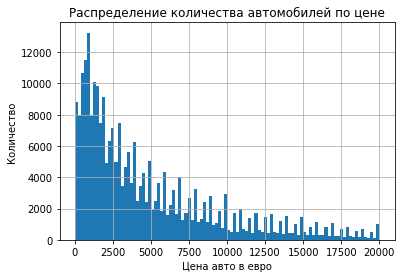

In [38]:
df['Price'].hist(bins=100)
#plt.xlim([-100,1000])

plt.xlabel("Цена авто в евро")
plt.ylabel("Количество")
plt.title('Распределение количества автомобилей по цене')
plt.show()

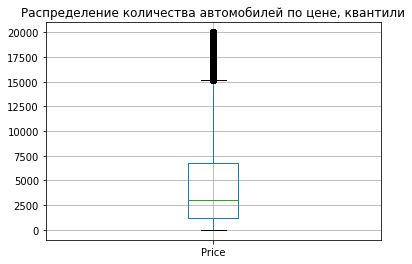

In [39]:
df.boxplot(column=['Price'])
plt.title('Распределение количества автомобилей по цене, квантили')
plt.show()

In [40]:
df['Price'].quantile([0.05, 0.95])

0.05      300.0
0.95    14900.0
Name: Price, dtype: float64

Оставим данные с ценой выше 200 евро и меньше 15000.

In [41]:
df = df.query('300 <= Price')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243831 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             243831 non-null  int64 
 1   VehicleType       243831 non-null  object
 2   RegistrationYear  243831 non-null  int64 
 3   Gearbox           243831 non-null  object
 4   Power             243831 non-null  int64 
 5   Model             243831 non-null  object
 6   Kilometer         243831 non-null  int64 
 7   FuelType          243831 non-null  object
 8   Brand             243831 non-null  object
 9   Repaired          243831 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.5+ MB


In [42]:
# Посмотрим уровень корреляции данных
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.487377,0.466482,-0.400739
RegistrationYear,0.487377,1.000000,0.131596,-0.290340
Power,0.466482,0.131596,1.000000,0.138898
Kilometer,-0.400739,-0.290340,0.138898,1.000000


Есть средняя корреляция между ценой и годом выпуска автомобиля и мощностью двигателя. Отрицательная корреляция с пробегом.

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>],
       [<AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

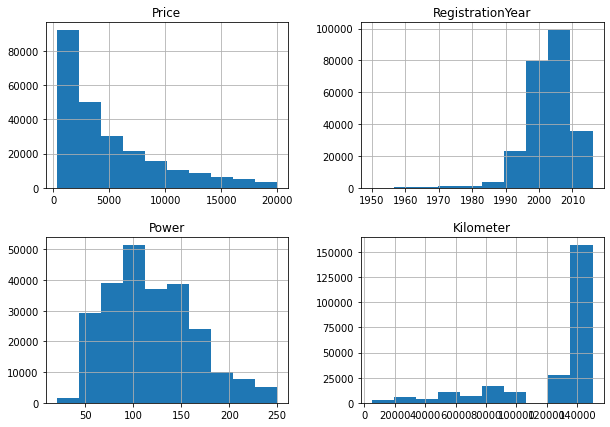

In [43]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca()

df.hist(ax=ax)

Посчитаем объем данных, которые остались после предобработки.

In [44]:
# еще раз проверим на дубдирование строк, после заполения пропущенных данных

df.duplicated().sum()

6596

In [45]:
# удалим дубликаты

df = df.drop_duplicates()

df.duplicated().sum()

0

In [46]:
df.shape

(237235, 10)

In [47]:
round(df.shape[0]/data.shape[0], 2)

0.67

### Вывод

- Изначальные данные содержат 354369 строк и 16 столбцов. Тип данных совпадает, есть пропуски и выбросы
- Избавились от столбцов, которые не влияют напрямую на целей признак - стоимость авто.А именно:

- LastSeen
- NumberOfPictures
- PostalCode
- DateCreated
- RegistrationMonth
- DateCrawled

- Перевели данные в столбцах типа object к нижнему регистру
- Удалили дубликаты - 45040 строк
- По каждому столбцу проверили неявные дубликаты и выбросы, заполнили пропуски

- Price: оставили авто с ценой в диапазоне 300 - 15000 евро
- VehicleType: заполнили пропуски типом other
- RegistrationYear: оставили авто с годами выпуска 1950-2020
- Gearbox: заполнили пропуски типом manual
- Power: оставили авто с мощностью двигателя 20-250 л.с.
- Model: заполнили пропуски как other
- Kilometer: без изменений
- FuelType: заполнили пропуски как other
- Brand: без изменений
- Repaired: заполнили пропущенные данные как no

- Очищенные данные составили 67% от изначальных 
- Строк 237235, столбцов 10 - достаточное количество для исследования
- Построены гистрограммы распределения данных
- Найдена средняя корреляция между ценой и годом выпуска автомобиля и мощностью двигателя. Отрицательная корреляция с пробегом.

## Обучение моделей

Посмотрим на наши данные еще раз

In [48]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [49]:
# сбросим индексы

df = df.reset_index(drop=True)

df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237235 entries, 0 to 237234
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             237235 non-null  int64 
 1   VehicleType       237235 non-null  object
 2   RegistrationYear  237235 non-null  int64 
 3   Gearbox           237235 non-null  object
 4   Power             237235 non-null  int64 
 5   Model             237235 non-null  object
 6   Kilometer         237235 non-null  int64 
 7   FuelType          237235 non-null  object
 8   Brand             237235 non-null  object
 9   Repaired          237235 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.1+ MB


### Шкалирование и кодирование данных

Разделим данные на целевой признак и фичи.

In [51]:
features = df.drop('Price', axis=1)
target = df['Price']

print(features.shape)
print(target.shape)

(237235, 9)
(237235,)


У нас есть категориальные и числовые признаки. Для обучения моделей нам необходимо кодировать категориальные признаки и провести шкалирование.

Для всех категориальных данных, кроме столбцов Brand и Model используем OneHotEncoding, а для них MEstimateEncoder.

In [52]:
# Кодируем данные без Brand и Model

features_ohe = features.drop(['Brand', 'Model'], axis=1)

features_ohe = pd.get_dummies(features_ohe, drop_first=True)

features_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes
0,2011,190,125000,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
1,2004,163,125000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,2001,75,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,2008,69,90000,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,1995,102,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1


In [53]:
features_ohe.shape

(237235, 18)

In [54]:
features_bm = features[['Brand', 'Model']]

features_bm

,Brand,Model
0,audi,other
1,jeep,grand
2,volkswagen,golf
3,skoda,fabia
4,bmw,3er
...,...,...
237230,alfa_romeo,159
237231,seat,leon
237232,smart,fortwo
237233,volkswagen,transporter


In [55]:
features_full = pd.concat([features_ohe, features_bm], sort = False, axis =1)

features_full.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes,Brand,Model
0,2011,190,125000,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,audi,other
1,2004,163,125000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,jeep,grand
2,2001,75,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,volkswagen,golf
3,2008,69,90000,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,skoda,fabia
4,1995,102,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,bmw,3er


In [56]:
features_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237235 entries, 0 to 237234
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   RegistrationYear         237235 non-null  int64 
 1   Power                    237235 non-null  int64 
 2   Kilometer                237235 non-null  int64 
 3   VehicleType_convertible  237235 non-null  uint8 
 4   VehicleType_coupe        237235 non-null  uint8 
 5   VehicleType_other        237235 non-null  uint8 
 6   VehicleType_sedan        237235 non-null  uint8 
 7   VehicleType_small        237235 non-null  uint8 
 8   VehicleType_suv          237235 non-null  uint8 
 9   VehicleType_wagon        237235 non-null  uint8 
 10  Gearbox_manual           237235 non-null  uint8 
 11  FuelType_electric        237235 non-null  uint8 
 12  FuelType_gasoline        237235 non-null  uint8 
 13  FuelType_hybrid          237235 non-null  uint8 
 14  FuelType_lpg        

In [57]:
# зафиксируем random_state

RS = 12345

In [58]:
# делим выборку на трейн/тест в пропорции 75/25

features_train, features_test, target_train, target_test = \
    train_test_split(features_full,target, test_size=0.25, random_state=RS)

# проверяем пропорции

print(round(features_train.shape[0]/features_ohe.shape[0],2))
print(round(features_test.shape[0]/features_ohe.shape[0],2))
print(round(target_train.shape[0]/target.shape[0],2))
print(round(target_test.shape[0]/target.shape[0],2))

0.75
0.25
0.75
0.25


In [59]:
# выведем размерности

print(features_train.shape)
print(features_test.shape)

(177926, 20)
(59309, 20)


In [60]:
# шкалируем данные, которые у нас изначально были числовыми

numeric_features = ['RegistrationYear', 'Power', 'Kilometer']

scaler=StandardScaler()
scaler.fit(features_train[numeric_features])


features_train[numeric_features]=scaler.transform(features_train[numeric_features])
features_test[numeric_features]=scaler.transform(features_test[numeric_features])


features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes,Brand,Model
205957,-0.765272,-0.672288,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,mazda,3_reihe
198678,-0.159246,0.274009,0.620374,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,audi,a4
40643,-0.916779,1.638436,0.620374,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,mercedes_benz,slk
113405,-0.159246,0.274009,0.620374,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,audi,a4
141301,-0.462259,-0.100108,0.620374,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,nissan,primera


In [61]:
features_test.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes,Brand,Model
218274,0.598287,-0.210143,-0.709401,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,peugeot,3_reihe
151968,-0.765272,-0.628274,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,audi,other
58690,1.204313,-1.266474,-2.039177,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,smart,fortwo
136033,-0.159246,-0.298170,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,volkswagen,golf
1303,-0.916779,0.141967,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,volkswagen,passat


In [62]:
#  сверяем размерности

print(features_train.shape)
print(features_test.shape)

(177926, 20)
(59309, 20)


Для  столбцов Brand и Model используем кодирование методом MEstimateEncoder.

In [63]:
encoder = MEstimateEncoder(cols=['Brand', 'Model'], 
                           handle_unknown= 'value',  
                           handle_missing = 'value')


encoder = encoder.fit (features_train, target_train) # Обучаем на обучающем наборе
features_train = encoder.transform (features_train) # Конвертировать обучающий набор
features_test = encoder.transform (features_test) # Конвертировать тестовый набор


 # handle_unknown и handle_missing установлены в "значение"
 # В целевом коде handle_unknown и handle_missing принимают только настройки «error», «return_nan» и «value»
 # По умолчанию оба значения - «значение», то есть среднее значение зависимой переменной в обучающем наборе для неизвестных категорий или отсутствующих значений.

In [64]:
#  сверяем размерности

print(features_train.shape)
print(features_test.shape)

(177926, 20)
(59309, 20)


In [65]:
# проверим, что вышло после кодирования

features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes,Brand,Model
205957,-0.765272,-0.672288,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,3999.094430,3516.384913
198678,-0.159246,0.274009,0.620374,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,6682.778121,6386.549728
40643,-0.916779,1.638436,0.620374,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,6053.545505,8759.258241
113405,-0.159246,0.274009,0.620374,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,6682.778121,6386.549728
141301,-0.462259,-0.100108,0.620374,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,4594.591775,1576.566700


In [66]:
features_test.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes,Brand,Model
218274,0.598287,-0.210143,-0.709401,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,3500.156420,3516.384913
151968,-0.765272,-0.628274,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,6682.778121,4217.762803
58690,1.204313,-1.266474,-2.039177,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,3711.031201,3770.966343
136033,-0.159246,-0.298170,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,5192.670944,4949.175455
1303,-0.916779,0.141967,0.620374,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,5192.670944,4971.467100


### Подготовка вычислений

In [67]:
# для дальнейших расчетов введем класс, подсчитывающий время выполнения обучения и предсказаний
# я подсмотрела его реализацию, но уж очень он мне нравится. Извините) 

In [68]:
class ModelHelper:
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = round(mean_squared_error(target, predicted)** 0.5, 2)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [69]:
# создадим датафрейм, в который будем вписывать все полученные значения, чтобы не собирать их вручную 

df_model = {'Model': [], 'FitTime': [], 'PredictedTime': [], 'RMSE': []} 
 
df_model = pd.DataFrame(df_model) 
 
df_model.head() 

,Model,FitTime,PredictedTime,RMSE


### LinearRegression

In [70]:
# создадим собственную функцию для подсчета rmse

def rmse(target, predicted):
    return round(mean_squared_error(target, predicted)** 0.5, 2)

In [71]:
my_scorer = make_scorer(rmse, greater_is_better=False)

In [72]:
# Для линейной регрессии GridSerachCV тоже можно использовать, с пустым словарём гиперпараметров
# - тогда будет просто выполнена кросс-валидация модели, что нам и нужно от линейной регрессии

params_LR = {}
model_LR = LinearRegression()

In [73]:
grid_LR = GridSearchCV(model_LR, params_LR, cv =3, scoring=my_scorer)
grid_LR.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LinearRegression(), param_grid={},
             scoring=make_scorer(rmse, greater_is_better=False))

In [74]:
abs(round(grid_LR.best_score_, 2))

2728.21

In [75]:
model_LR_best = grid_LR.best_estimator_

In [76]:
# делаем расчеты для модели Линейной Регрессии и вносим в таблицу расчеты
# %time - покажет время исполнения

%time


model_LR_helper = ModelHelper('LinearRegression', model_LR_best )
model_LR_helper.fit(features_train, target_train)
model_LR_helper.predict(features_test, target_test)

df_model.loc[len(df_model.index)] = model_LR_helper.getResult()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [77]:
df_model.head()

,Model,FitTime,PredictedTime,RMSE
0,LinearRegression,0.277474,0.110767,2742.19


### RandomForestRegressor

In [78]:
# установим небольшие параметры, чтобы не ждать часами

params_RFG = { 'n_estimators': range (1,10,1),
              'max_depth': range (1,10, 1)}

model_RFG = RandomForestRegressor(random_state= RS)

In [79]:
# подберем лучшие параметры с помощью GridSearchCV

grid_RFG = GridSearchCV(model_RFG, params_RFG, cv =3, scoring=my_scorer)
grid_RFG.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 10)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [80]:
# узнаем лучшие параметры

grid_RFG.best_params_

{'max_depth': 9, 'n_estimators': 9}

In [81]:
# показатель RMSE

abs(round(grid_RFG.best_score_, 2))

1869.51

In [82]:
model_RFG_best = grid_RFG.best_estimator_

In [83]:
# вносим данные в таблицу с результатами лучшей выбранной модели

%time

model_RFG_helper = ModelHelper('RandomForestRegressor', model_RFG_best)
model_RFG_helper.fit(features_train, target_train)
model_RFG_helper.predict(features_test, target_test)

df_model.loc[len(df_model.index)] = model_RFG_helper.getResult()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [84]:
df_model.head()

,Model,FitTime,PredictedTime,RMSE
0,LinearRegression,0.277474,0.110767,2742.19
1,RandomForestRegressor,3.306131,0.061942,1852.82


### CatBoostRegressor

Будем обучать модель на изначальных данных, выделив категориальные.

In [85]:
# чтобы не менять изначальные данные features, копируем их для обработки 
# делим отшкалированные данные на трейн/тест в пропорции 75/25
features_cbr = features.copy()

features_train_cbr, features_test_cbr, target_train_cbr, target_test_cbr = \
    train_test_split(features_cbr,target, test_size=0.25, random_state=RS)

# проверяем пропорции

print(round(features_train_cbr.shape[0]/features_cbr.shape[0],2))
print(round(features_test_cbr.shape[0]/features_cbr.shape[0],2))
print(round(target_train_cbr.shape[0]/target.shape[0],2))
print(round(target_test_cbr.shape[0]/target.shape[0],2))


print(features_train_cbr.shape)
print(features_test_cbr.shape)

0.75
0.25
0.75
0.25
(177926, 9)
(59309, 9)


In [86]:
# снова шкалируем данные 

scaler.fit(features_train_cbr[numeric_features])


features_train_cbr[numeric_features]=scaler.transform(features_train_cbr[numeric_features])
features_test_cbr[numeric_features]=scaler.transform(features_test_cbr[numeric_features])

print(features_train_cbr.shape)
print(features_test_cbr.shape)


features_train_cbr.head()

(177926, 9)
(59309, 9)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
205957,sedan,-0.765272,manual,-0.672288,3_reihe,0.620374,petrol,mazda,yes
198678,wagon,-0.159246,manual,0.274009,a4,0.620374,gasoline,audi,no
40643,convertible,-0.916779,manual,1.638436,slk,0.620374,petrol,mercedes_benz,no
113405,wagon,-0.159246,manual,0.274009,a4,0.620374,gasoline,audi,no
141301,wagon,-0.462259,manual,-0.100108,primera,0.620374,petrol,nissan,no


In [87]:
features_test_cbr.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
218274,sedan,0.598287,manual,-0.210143,3_reihe,-0.709401,petrol,peugeot,no
151968,sedan,-0.765272,manual,-0.628274,other,0.620374,petrol,audi,yes
58690,small,1.204313,manual,-1.266474,fortwo,-2.039177,petrol,smart,no
136033,sedan,-0.159246,manual,-0.298170,golf,0.620374,petrol,volkswagen,yes
1303,sedan,-0.916779,manual,0.141967,passat,0.620374,petrol,volkswagen,no


In [88]:
# выделяем категориальные данные

features_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [89]:
# выбрали небольшие параметры для скорости расчетов

model_CBR = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=features_cat, random_seed=RS)

params_CBR = {'iterations': range(1, 50,10),
              'depth': range(1,10,1)}

grid_CBR = GridSearchCV(model_CBR, params_CBR , cv=3, scoring= my_scorer)
grid_CBR.fit(features_train_cbr, target_train_cbr)

grid_CBR.best_params_

{'depth': 9, 'iterations': 41}

In [90]:
abs(round(grid_CBR.best_score_, 2))

1631.61

In [91]:
model_CBR_best = grid_CBR.best_estimator_

In [92]:
# вносим данные в таблицу с результатами лучшей выбранной модели

%time

model_CBR_helper = ModelHelper('CatBoostRegressor', model_CBR_best)
model_CBR_helper.fit(features_train_cbr, target_train_cbr)
model_CBR_helper.predict(features_test_cbr, target_test_cbr)

df_model.loc[len(df_model.index)] = model_CBR_helper.getResult()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [93]:
df_model.head()

,Model,FitTime,PredictedTime,RMSE
0,LinearRegression,0.277474,0.110767,2742.19
1,RandomForestRegressor,3.306131,0.061942,1852.82
2,CatBoostRegressor,4.596615,0.146933,1621.39


### LightGBM 

In [94]:
model_LGBM = LGBMRegressor(verbose=-1, random_seed =RS)

params_LGMB = {'n_estimators': range(1, 30, 2), 'num_leaves': range(20, 41, 20)}

grid_LGMB = GridSearchCV(model_LGBM, params_LGMB, cv=3, scoring = my_scorer)
grid_LGMB.fit(features_train, target_train)

grid_LGMB.best_params_

{'n_estimators': 29, 'num_leaves': 40}

In [95]:
abs(round(grid_LGMB.best_score_, 2))

1781.05

In [96]:
model_LGMB_best = grid_LGMB.best_estimator_

In [97]:
# вносим данные в таблицу с результатами лучшей выбранной модели

%time

model_LGMB_helper = ModelHelper('LightGMB', model_LGMB_best)
model_LGMB_helper.fit(features_train, target_train)
model_LGMB_helper.predict(features_test, target_test)

df_model.loc[len(df_model.index)] = model_LGMB_helper.getResult()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [98]:
df_model.head()

,Model,FitTime,PredictedTime,RMSE
0,LinearRegression,0.277474,0.110767,2742.19
1,RandomForestRegressor,3.306131,0.061942,1852.82
2,CatBoostRegressor,4.596615,0.146933,1621.39
3,LightGMB,15.367894,0.199019,1773.80


### Вывод

Лучшие показатель RMSE показала модель CatBoostRegressor. Время обучения больше, чем у RandomForestRegressor, но время предсказаний сравнимо с этой моделью, а точность предсказания выше. 

## Анализ моделей

In [99]:
df_model.head()

,Model,FitTime,PredictedTime,RMSE
0,LinearRegression,0.277474,0.110767,2742.19
1,RandomForestRegressor,3.306131,0.061942,1852.82
2,CatBoostRegressor,4.596615,0.146933,1621.39
3,LightGMB,15.367894,0.199019,1773.80


- Мы обучили 4 вида моделей на предоставленных данных.
- Не все модели показали RMSE < 2500, Линейная Регрессия показала RMSE = 2742,19
- Лучшие показатели RMSE у моделей градиентного бустинга. Они обучаются чуть дольше модели RandomForestRegressor, но дают гораздо большую точность предсказаний.
- Лучший показатель RMSE показала модель CatBoostRegressor. Время обучения больше, чем у RandomForestRegressor, но время предсказаний сравнимо с этой моделью, а точность предсказания выше. 